# 숙명여자대학교 기계시스템학부 딥러닝 2024: Lab6

## Topic: **LSTM for Time Series**
## (강사: 심주용)


### Data Description

LSTM-based control system for artificial muscles, focusing on the setup and data manipulation for shape memory alloy (SMA) actuators.
- 해결하려는 문제: 인공근육의 제어의 어려움 (힘이 입력 전류와 주변 환경에 따라 민감하게 변함).
- 해결 방법: Deep Learning 학습 기반의 Time Series 예측 모델을 이용하여 힘을 예측하고 제어한다.

### Input Data:
- **Current (A)**, **Resistence 1 (Ohm)**, **Resistance 2(Ohm)** recorded from 100 time points. Normalized to  0~1.


### Output Data:
- **Force (N)**: Force output (N) by the SMA actuator for 100 data points. Normalized to  0~1.

Each of these data points forms a part of the dataset used by the LSTM model to train and make predictions about the force output based on current, resistance, and temperature, enhancing the control and responsiveness of SMA actuators in various applications.

<center>
<img src='https://drive.google.com/uc?id=11zDzR5VnOfsAz2uUnrMluaJaU7HHZxWD' width="600" height="500" /> <br>
</center>

### Long Short-Term Memory (LSTM) model for sequence prediction tasks

Workflow from data loading and preprocessing to model training, evaluation, and visualization of results:

1. **Data Loading**: The script begins by loading training, validation, and testing sequences from NumPy files. These sequences are presumably time-series data or similar structured data appropriate for LSTM processing.

2. **Data Visualization**: Before diving into the model building, the script visualizes the first five sequences from the training set. This visualization plots four features per sequence to help understand the data characteristics.

--2024-05-16 06:13:41--  https://www.dropbox.com/scl/fi/uhmrn7hykc9cpc5z4yds6/test_sequences.npy?rlkey=xa9f10ps5o2orcvgc9sgbzg7a
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf0e517249a472acc09294ad70.dl.dropboxusercontent.com/cd/0/inline/CS9SCCUHoxAZVTn1ome1e0lG9b8pDW44EgbaF40_zuWT_WVjaEH_ZU_W_Cc93CA_NmQ7scS2OsKhRHEvzlJrJGEFIcwpShIhBMUaKY1zZXWsNx9unn8q49dLrwdmgEGc6CSKrWAb87kv338GfXOCTu7m/file# [following]
--2024-05-16 06:13:42--  https://ucaf0e517249a472acc09294ad70.dl.dropboxusercontent.com/cd/0/inline/CS9SCCUHoxAZVTn1ome1e0lG9b8pDW44EgbaF40_zuWT_WVjaEH_ZU_W_Cc93CA_NmQ7scS2OsKhRHEvzlJrJGEFIcwpShIhBMUaKY1zZXWsNx9unn8q49dLrwdmgEGc6CSKrWAb87kv338GfXOCTu7m/file
Resolving ucaf0e517249a472acc09294ad70.dl.dropboxusercontent.com (ucaf0e517249a472acc09294ad70.dl.dropboxusercontent.com)... 162.125.1.15, 

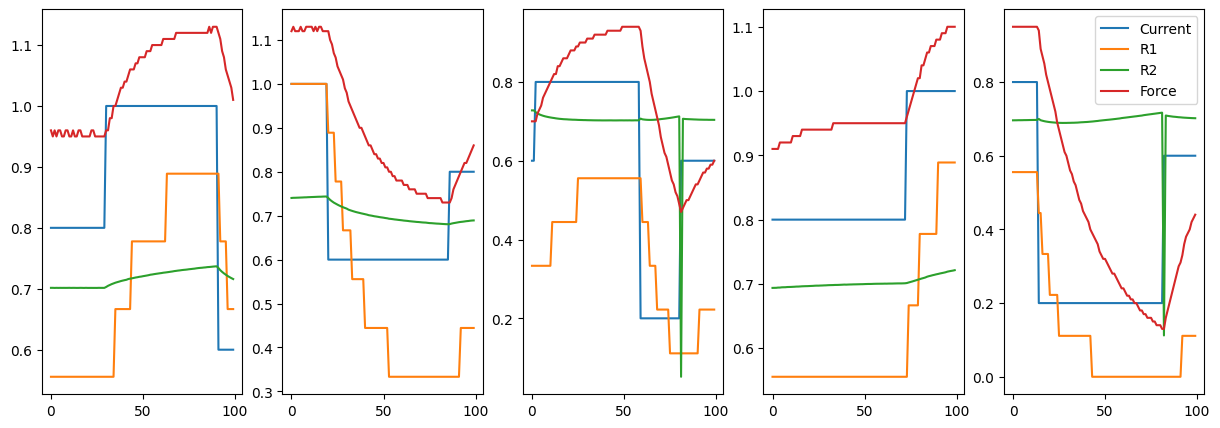

In [1]:
import random
import time
import numpy as np
import os
import scipy.io as sio
from natsort import natsorted
from torch.utils.data import Dataset

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

!wget -O test_sequences.npy https://www.dropbox.com/scl/fi/uhmrn7hykc9cpc5z4yds6/test_sequences.npy?rlkey=xa9f10ps5o2orcvgc9sgbzg7a&dl=0
!wget -O train_sequences.npy https://www.dropbox.com/scl/fi/9b2i3wvgjr5iz50kl6ykd/train_sequences.npy?rlkey=bjpm4fkxowqyttayaxk1hupml&dl=0
!wget -O val_sequences.npy https://www.dropbox.com/scl/fi/i44ppl460qjg28ichzn4w/val_sequences.npy?rlkey=yv35ctho32ji0853mac45duex&dl=0

train_sequences = np.load('train_sequences.npy')
val_sequences = np.load('val_sequences.npy')
test_sequences = np.load('test_sequences.npy')

plt.figure(figsize=(15,5))
for j in range(5):
    plt.subplot(1,5,j+1)
    plt.plot(train_sequences[j][:,0])
    plt.plot(train_sequences[j][:,1])
    plt.plot(train_sequences[j][:,2])
    plt.plot(train_sequences[j][:,3])
plt.legend(['Current','R1','R2','Force'])

In [2]:
val_sequences.shape, train_sequences.shape, test_sequences.shape

((2059, 100, 4), (16468, 100, 4), (2059, 100, 4))

### 3. **Dataset Preparation**
A custom PyTorch dataset class, `SSS_Dataset`, is defined to handle the sequences. This class is responsible for formatting the data into a suitable structure for the LSTM model, separating the features from the labels and ensuring data is correctly converted into PyTorch tensors.

In [3]:
class SSS_Dataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        temp= self.sequences[idx]
        a,b = temp.shape
        b = b-1
        sequence,label =temp[:,:b],temp[:,b]
        return dict(
            sequence=torch.tensor(sequence).float(),
            label=torch.tensor(label).float()
        )

train_dataset = SSS_Dataset(train_sequences)
test_dataset = SSS_Dataset(test_sequences)
valid_dataset = SSS_Dataset(val_sequences)

### Model Definition & Training

4. **Device Configuration**: It checks whether a GPU is available for training (using CUDA) and sets the device accordingly, which facilitates faster model training.

5. **Model Configuration and Definition**:
    - A configuration class `LstmConfig` is created to store hyperparameters such as the number of LSTM layers, hidden dimensions, dropout rate, learning rate, etc.
    - An `LSTM_Model` class is defined inheriting from `nn.Module`, encapsulating the LSTM architecture. This model includes an LSTM layer followed by a dropout layer for regularization and a fully connected layer for output generation.


<center>
<img src='https://drive.google.com/uc?id=1cN_3q1E1mn7r7qq8WSpxszJiDYkhmHys' width="450" height="300" /> <br>
</center>


6. **Model Instantiation and Optimizer Setup**: The model is instantiated with the appropriate input dimensions and moved to the specified device (CPU or GPU). An Adam optimizer is configured with the defined learning rate.

7. **DataLoader Setup**: DataLoader instances for training, testing, and validation datasets are prepared. These are used to batch the data for efficient processing during the training and evaluation phases.

8. **Training and Evaluation Loop**:
    - The script executes training over a specified number of epochs. For each epoch, it iterates over the training DataLoader, computes the loss (using L1Loss), and updates the model parameters.
    - Post training in each epoch, the model's performance is evaluated using the test DataLoader. The losses for both training and testing phases are tracked and printed.

9. **Testing and Prediction Visualization**:
    - After completing the training, the model is used to make predictions on the test set.
    - A random prediction and the corresponding actual label are visualized to demonstrate the model’s performance.

10. **Result Visualization**: Finally, the script randomly selects a test sequence and compares its actual and predicted values graphically to provide a visual assessment of the model's predictive accuracy.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.2510, Test Loss: 0.1631
Epoch 2/20, Train Loss: 0.1477, Test Loss: 0.1135
Epoch 3/20, Train Loss: 0.1206, Test Loss: 0.1072
Epoch 4/20, Train Loss: 0.1043, Test Loss: 0.0807
Epoch 5/20, Train Loss: 0.0950, Test Loss: 0.0816
Epoch 6/20, Train Loss: 0.0894, Test Loss: 0.0812
Epoch 7/20, Train Loss: 0.0854, Test Loss: 0.0698
Epoch 8/20, Train Loss: 0.0814, Test Loss: 0.0615
Epoch 9/20, Train Loss: 0.0792, Test Loss: 0.0637
Epoch 10/20, Train Loss: 0.0756, Test Loss: 0.0552
Epoch 11/20, Train Loss: 0.0740, Test Loss: 0.0559
Epoch 12/20, Train Loss: 0.0710, Test Loss: 0.0595
Epoch 13/20, Train Loss: 0.0699, Test Loss: 0.0539
Epoch 14/20, Train Loss: 0.0684, Test Loss: 0.0528
Epoch 15/20, Train Loss: 0.0671, Test Loss: 0.0513
Epoch 16/20, Train Loss: 0.0657, Test Loss: 0.0492
Epoch 17/20, Train Loss: 0.0644, Test Loss: 0.0473
Epoch 18/20, Train Loss: 0.0642, Test Loss: 0.0487
Epoch 19/20, Train Loss: 0.0626, Test Loss: 0.0467
Epoch 20/20, Train Loss: 0.0620, Test Lo

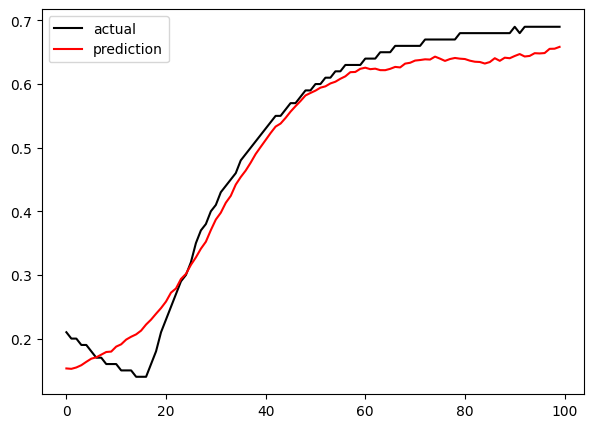

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

class LstmConfig :
    layer_dim = 1
    hidden_dim = 27
    dropout_l0= 0.1
    lr= 0.001
    optimizer_name="Adam"
    BATCH_SIZE = 32
    EPOCHS = 20
cf = LstmConfig()
criterion = torch.nn.L1Loss()

class LSTM_Model(nn.Module):
    def __init__(self,input_dim,device,hidden_dim=cf.hidden_dim,layer_dim=cf.layer_dim,output_dim=100):
        super(LSTM_Model,self).__init__()
        self.hidden_dim=hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.dropout = nn.Dropout(cf.dropout_l0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, x):
        # Pass the inputs through the LSTM
        out, (hn, cn) = self.lstm(x)
        out = self.dropout(out)
        # Compute the output
        out = self.fc(out[:, -1, :])
        return out

input_dim,n_features = train_dataset[0]['sequence'].shape
model = LSTM_Model(n_features, device).to(device)
optimizer = optim.Adam(model.parameters(), lr = cf.lr)

train_dataloader = DataLoader(train_dataset, cf.BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, cf.BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, cf.BATCH_SIZE)

train_losses=[]
test_losses=[]
for epoch in tqdm(range(cf.EPOCHS)):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for train_batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(train_batch["sequence"].to(device))
        loss = criterion(outputs, train_batch["label"].to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for test_batch in valid_dataloader:
            outputs = model.forward(test_batch["sequence"].to(device))
            loss = criterion(outputs, test_batch["label"].to(device))
            test_loss += loss.item()
    train_loss = train_loss / len(valid_dataloader)
    test_loss = test_loss / len(valid_dataloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{cf.EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

model.eval()
predictions_seq=[]
actual_seq = []
input_seq = []
with torch.no_grad():
    for test_batch in test_dataloader:
        pred = model(test_batch["sequence"].to(device))
        label = test_batch["label"].to(device)
        input_temp = test_batch["sequence"].cpu().numpy()

        predictions=pred.cpu().numpy()
        predictions_seq.append(predictions)
        true = label.cpu().numpy()
        actual_seq.append(true)
        input_seq.append(input_temp)

jdx, kdx = np.random.randint(65), np.random.randint(32)
plt.figure(figsize=(7,5))
plt.plot(actual_seq[jdx][kdx], label='actual',color="black")
plt.plot(predictions_seq[jdx][kdx], label='prediction',color="red")
plt.legend()
plt.show()

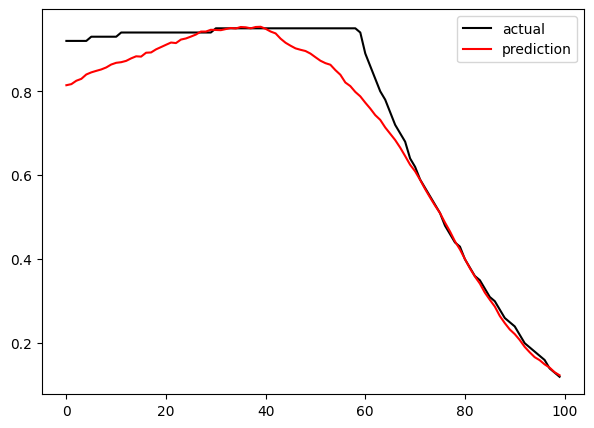

In [13]:
jdx, kdx = np.random.randint(65), np.random.randint(32)
plt.figure(figsize=(7,5))
plt.plot(actual_seq[jdx][kdx], label='actual',color="black")
plt.plot(predictions_seq[jdx][kdx], label='prediction',color="red")
plt.legend()
plt.show()